In [ ]:
%load_ext autoreload
%autoreload 2

%autosave 10

#%load_ext lab_black

In [ ]:
import sys
import os

sys.path.insert(0, os.path.abspath(os.path.join("..")))

## Imports

In [ ]:
from lfp_analysis.data import *
from lfp_analysis.process import *
# from lfp_analysis.resnet2d import *
from lfp_analysis.resnet1d import *
from lfp_analysis.svm import *

from fastai.vision.all import *
import torch.nn.functional as F
from torchvision.transforms import ToPILImage, ToTensor

In [ ]:
import numpy as np
import pandas as pd
import h5py

from pathlib import Path

import matplotlib.pyplot as plt

%matplotlib inline

In [ ]:
def plot_roc_instance(roc_curve_cont,ax=None,color=None,label=None):
    
    mean_fpr = np.linspace(0, 1, 100)
    if ax is None:
        fig,ax = plt.subplots()
    
    ax.plot([0,1],[0,1],color='k',alpha=0.5,linestyle='--',linewidth=0.4)
    ax.set_xlabel("False Positive Rate")
    ax.set_ylabel("True Positve Rate")
    
    ax.plot(mean_fpr,roc_curve_cont['mean'],color=color,label=label)
    ax.fill_between(mean_fpr,
                    roc_curve_cont['mean']-roc_curve_cont['std'],
                    roc_curve_cont['mean']+roc_curve_cont['std'],
                    alpha=0.2,color=color
                   )


In [ ]:
import seaborn as sns

def plot_conf_mats(conf_mats):
    
    fig,ax = plt.subplots(3,1,figsize=(4,10))
    
    max_val = max([np.max(conf_mats["svm"]["mean"]),np.max(conf_mats["lda"]["mean"]),np.max(conf_mats["1d-cnn"])])
    #max_val = int(1.2*max_val)
    min_val = min([np.min(conf_mats["svm"]["mean"]),np.min(conf_mats["lda"]["mean"]),np.min(conf_mats["1d-cnn"])])
    #min_val = int(0.8*min_val)
    
    for ii,cls_name in enumerate(["svm","lda"]):
        means, stds = conf_mats[cls_name]["mean"], conf_mats[cls_name]["std"]
        annot = pd.DataFrame([[f"{mean:.1f} +/- {std:.2f}" for mean,std in zip(mean_outer,std_outer)] for mean_outer,std_outer in zip(means,stds)])
    
        df = pd.DataFrame(conf_mats[cls_name]['mean'],index=[0,1],columns=[0,1])

        sns.heatmap(df,annot=annot,vmin=min_val,vmax=max_val,ax=ax[ii],fmt="s",cmap="rocket")
        ax[ii].set_title(cls_name)
        ax[ii].set_ylabel("True Label")
    
    df = pd.DataFrame(conf_mats["1d-cnn"],index=[0,1],columns=[0,1])

    sns.heatmap(df,annot=True,vmin=min_val,vmax=max_val,ax=ax[2],fmt=".2f",cmap="rocket")
    ax[2].set_title("1d-cnn")
    ax[2].set_xlabel("Predicted Label")
    ax[2].set_ylabel("True Label")


    return fig,ax


def plot_conf_mats(conf_mats):
    
    fig,ax = plt.subplots(5,1,figsize=(4,18))
    
    ml_keys = ['svm','b-lda','th-lda']
    nn_keys = ['1d-cnn','2d-cnn']
    
    max_val = max([np.max(conf_mats[key]["mean"]) for key in ml_keys]+[np.max(conf_mats[key]) for key in nn_keys])
    min_val = min([np.min(conf_mats[key]["mean"]) for key in ml_keys]+[np.min(conf_mats[key]) for key in nn_keys])
    
    for ii,cls_name in enumerate(ml_keys):
        means, stds = conf_mats[cls_name]["mean"], conf_mats[cls_name]["std"]
        annot = pd.DataFrame([[f"{mean:.1f} +/- {std:.2f}" for mean,std in zip(mean_outer,std_outer)] for mean_outer,std_outer in zip(means,stds)])
    
        df = pd.DataFrame(conf_mats[cls_name]['mean'],index=[0,1],columns=[0,1])

        sns.heatmap(df,annot=annot,vmin=min_val,vmax=max_val,ax=ax[ii],fmt="s",cmap="rocket")
        ax[ii].set_title(cls_name)
        ax[ii].set_ylabel("True Label")
    
    for ii,cls_name in enumerate(nn_keys):
        df = pd.DataFrame(conf_mats[cls_name],index=[0,1],columns=[0,1])

        sns.heatmap(df,annot=True,vmin=min_val,vmax=max_val,ax=ax[3+ii],fmt=".2f",cmap="rocket")
        ax[3+ii].set_title(cls_name)
        ax[3+ii].set_ylabel("True Label")

    ax[-1].set_xlabel("Predicted Label")
    return fig,ax

In [ ]:
def plot_svm_coefs(svm_coef_cont):
    n_chan = len(svm_coef_cont['th_lda_scores']['mean'])

    comp = 1

    fig,ax = plt.subplots(n_chan,1,sharey=True,sharex=True,figsize=(4,6))

    for i in range(n_chan):
        idx_svm = list(range(i*(len(svm_coef_cont['svm_scores']['mean'])//n_chan),(i+1)*(len(svm_coef_cont['svm_scores']['mean'])//n_chan)))
        ax[i].errorbar(np.array(range(len(idx_svm)))/comp,svm_coef_cont['svm_scores']['mean'][idx_svm],yerr=svm_coef_cont['svm_scores']['std'][idx_svm],marker='o',linestyle='none',c='C0',markersize=3)

        idx_b_lda = list(range(i*(len(svm_coef_cont['b_lda_scores']['mean'])//n_chan),(i+1)*(len(svm_coef_cont['b_lda_scores']['mean'])//n_chan)))
        ax[i].errorbar(np.array(range(2,4))/comp,svm_coef_cont['b_lda_scores']['mean'][idx_b_lda],yerr=svm_coef_cont['b_lda_scores']['std'][idx_b_lda],marker='o',linestyle='none',c='C3',markersize=3)

        idx_th_lda = list(range(i*(len(svm_coef_cont['th_lda_scores']['mean'])//n_chan),(i+1)*(len(svm_coef_cont['th_lda_scores']['mean'])//n_chan)))
        ax[i].errorbar(np.array(range(len(idx_th_lda)))/comp,svm_coef_cont['th_lda_scores']['mean'][idx_th_lda],yerr=svm_coef_cont['th_lda_scores']['std'][idx_th_lda],marker='o',linestyle='none',c='C4',markersize=3)

    ax[-1].set_xticks(np.array(range(len(idx_svm)))/comp)
    labels = [el[5:-2] for el in list(np.array(svm_coef_cont['svm_scores']['names']).squeeze()[idx_svm])]
    ax[-1].set_xticklabels(labels,rotation=35)
    ax[0].set_title("LinearSVM Coefs")
    ax[0].set_ylim((-2,2))

    return ax



In [ ]:
def get_metric(results,metric,cls=None):

    if cls is None:
        return {'svm':results['svm_scores'][metric],
                'b-lda':results['b_lda_scores'][metric],
                'th-lda':results['th_lda_scores'][metric],
                '1d-cnn':results['1d_cnn_scores'][metric],
                '2d-cnn':results['2d_cnn_scores'][metric]}

    else:
        return {name:results[name][metric] for name in cls}

In [ ]:
DATA_PATH = Path("./../data")
PAT_ID = Path('ET4')
DATASET_NAME = Path('Pegboard_off')

LFP_SOURCE = DATA_PATH / 'preprocessed' / PAT_ID / DATASET_NAME.with_suffix('.h5')
H5_SOURCE = DATA_PATH / 'TF_and_df' / PAT_ID / DATASET_NAME.with_suffix('.h5')
CSV_SOURCE = DATA_PATH / 'TF_and_df' / PAT_ID / DATASET_NAME.with_suffix('.csv')

missing_datasets = {3: 'Pouring', 5: 'Pegboard', 6: 'Pegboard', 8: 'Pegboard' }

svm_c = "C0"
cnn1d_c = "C1"
cnn2d_c = "C2"
b_lda_c = "C3"
th_lda_c = "C4"

palette = plt.rcParams['axes.prop_cycle'].by_key()['color']
cls_keys = ['svm_scores', '1d_cnn_scores', '2d_cnn_scores', 'b_lda_scores', 'th_lda_scores']


In [ ]:
PKL_TARGET = DATA_PATH / 'results' / PAT_ID / DATASET_NAME.with_suffix('.p')
FIG_TARGET = DATA_PATH / 'results' / PAT_ID / Path(str(DATASET_NAME)+'_runAllv1').with_suffix('.png')
FIG_TARGET_CONF = DATA_PATH / 'results' / PAT_ID / Path(str(DATASET_NAME)+"_conf").with_suffix('.png')

In [ ]:
import pickle
results = pickle.load(open(PKL_TARGET,"rb"))

In [ ]:
svm_coef_cont = get_metric(results,"svm_coef",cls=["svm_scores","b_lda_scores","th_lda_scores"])


In [ ]:
plt.close('all')

In [ ]:
plot_svm_coefs(svm_coef_cont)

In [ ]:
for ii in range(1, 9):

    for set_id, dataset in enumerate(["Pegboard", "Pouring", "Posture"]):

        x_coord = ii*offset_pat + set_id * offset_set
        if dataset == "Pouring":
            xticks.append(x_coord + 2*offset_cls)
            xticklabels.append(f"ET{ii}")

        try:
            missing_for_pat = missing_datasets[ii]
        except:
            missing_for_pat = dict()

        if dataset not in missing_for_pat:
            PKL_SOURCE = (
                DATA_PATH
                / "results"
                / f"ET{ii}"
                / Path(dataset + "_off").with_suffix(".p")
            )
            results = pickle.load(open(PKL_SOURCE, "rb"))

            svm_coef_cont = get_metric(results,"svm_coef",cls=["svm_scores","b_lda_scores","th_lda_scores"])
            plot_svm_coefs(svm_coef_cont)

            FIG_TARGET = DATA_PATH / 'results' / f"ET{ii}" / Path(dataset+'_svmCoef_runAllv1').with_suffix('.png')
            plt.savefig(FIG_TARGET)


In [ ]:
for ii in range(1, 9):

    for set_id, dataset in enumerate(["Pegboard", "Pouring", "Posture"]):

        x_coord = ii*offset_pat + set_id * offset_set
        if dataset == "Pouring":
            xticks.append(x_coord + 2*offset_cls)
            xticklabels.append(f"ET{ii}")

        try:
            missing_for_pat = missing_datasets[ii]
        except:
            missing_for_pat = dict()

        if dataset not in missing_for_pat:
            PKL_SOURCE = (
                DATA_PATH
                / "results"
                / f"ET{ii}"
                / Path(dataset + "_off").with_suffix(".p")
            )
            results = pickle.load(open(PKL_SOURCE, "rb"))

            FIG_TARGET = DATA_PATH / 'results' / f"ET{ii}" / Path(dataset+'_confMats_runAllv1').with_suffix('.png')

            plot_conf_mats(get_metric(results,'conf_mat_norm'));        

            plt.savefig(FIG_TARGET)

In [ ]:
plt.close('all')

In [ ]:
for ii in range(1, 9):

    for set_id, dataset in enumerate(["Pegboard", "Pouring", "Posture"]):

        x_coord = ii*offset_pat + set_id * offset_set
        if dataset == "Pouring":
            xticks.append(x_coord + 2*offset_cls)
            xticklabels.append(f"ET{ii}")

        try:
            missing_for_pat = missing_datasets[ii]
        except:
            missing_for_pat = dict()

        if dataset not in missing_for_pat:
            PKL_SOURCE = (
                DATA_PATH
                / "results"
                / f"ET{ii}"
                / Path(dataset + "_off").with_suffix(".p")
            )
            results = pickle.load(open(PKL_SOURCE, "rb"))

            FIG_TARGET = DATA_PATH / 'results' / f"ET{ii}" / Path(dataset+'_runAllv1').with_suffix('.png')


            fig,ax = plt.subplots()

            plot_roc_instance(results['svm_scores']['roc_curve'],ax=ax,label=f"SVM (AUC: {results['svm_scores']['AUC']['valid']['mean']:.2f} +/- {results['svm_scores']['AUC']['valid']['std']:.2f})",color='C0')


            ax.plot(results['1d_cnn_scores']['roc_curve'][0],results['1d_cnn_scores']['roc_curve'][1],label=f"1d-CNN (AUC: {results['1d_cnn_scores']['AUC']['valid']:.2f})",color='C1')
            ax.plot(results['2d_cnn_scores']['roc_curve'][0],results['2d_cnn_scores']['roc_curve'][1],label=f"2d-CNN (AUC: {results['2d_cnn_scores']['AUC']['valid']:.2f})",color='C2')

            plot_roc_instance(results['b_lda_scores']['roc_curve'],ax=ax,label=f"b-LDA (AUC: {results['b_lda_scores']['AUC']['valid']['mean']:.2f} +/- {results['b_lda_scores']['AUC']['valid']['std']:.2f})",color='C3')
            plot_roc_instance(results['th_lda_scores']['roc_curve'],ax=ax,label=f"th-LDA (AUC: {results['th_lda_scores']['AUC']['valid']['mean']:.2f} +/- {results['th_lda_scores']['AUC']['valid']['std']:.2f})",color='C4')
            ax.legend(loc="lower right")

            plt.savefig(FIG_TARGET)

In [ ]:
plt.savefig(FIG_TARGET)

In [237]:

accs = [get_metric(results,'accuracy')[key]['valid'] for key in ['svm','1d-cnn', '2d-cnn','b-lda', 'th-lda']]
accs = [el['mean'] if isinstance(el,dict) else el for el in accs]

aucs = [get_metric(results,'AUC')[key]['valid'] for key in ['svm','1d-cnn', '2d-cnn','b-lda', 'th-lda']]
aucs = [el['mean'] if isinstance(el,dict) else el for el in aucs]

In [241]:
np.array(list(zip(accs,aucs))).flatten()

array([0.64530387, 0.67875161, 0.74585635, 0.80374805, 0.71823204,
       0.73063063, 0.61381215, 0.62558559, 0.49723757, 0.6541184 ])

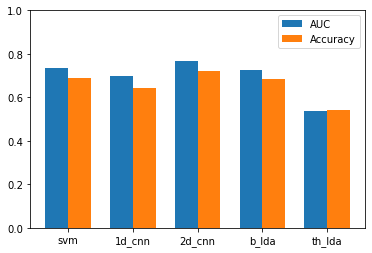

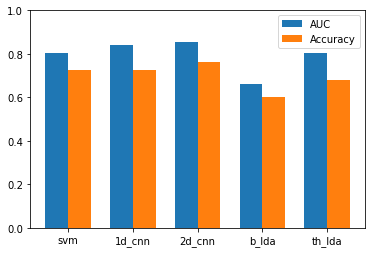

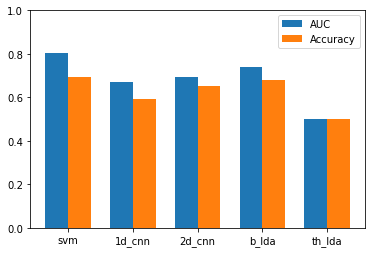

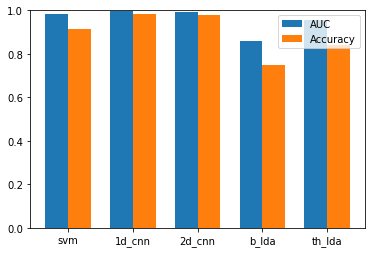

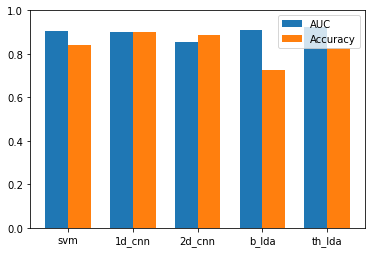

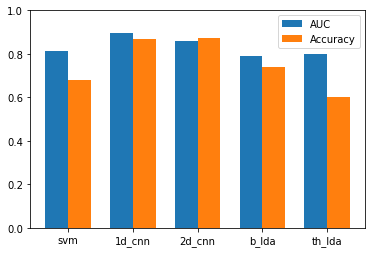

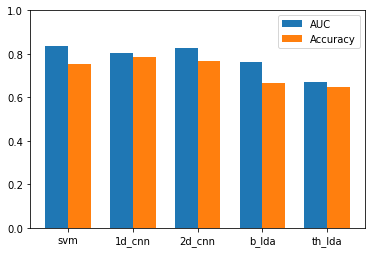

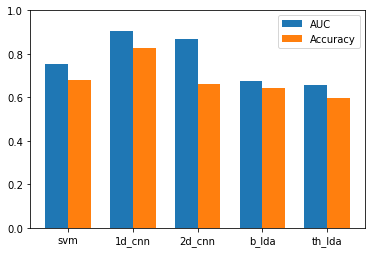

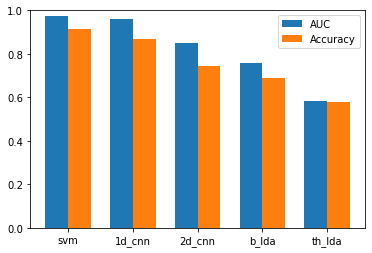

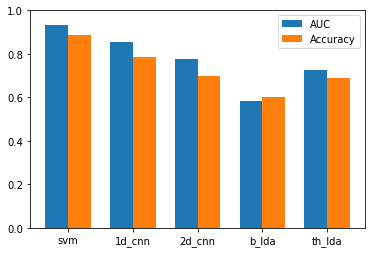

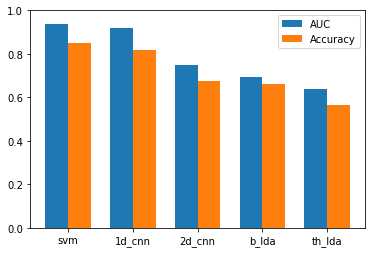

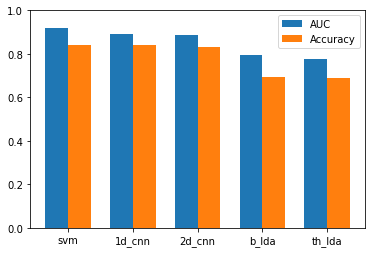

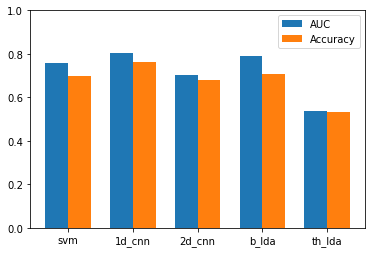

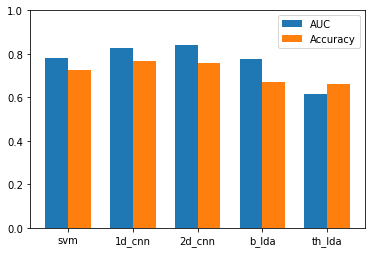

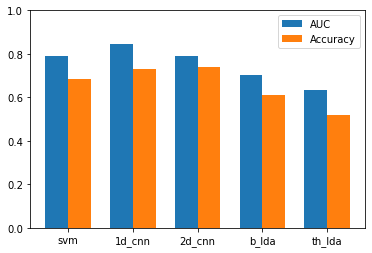

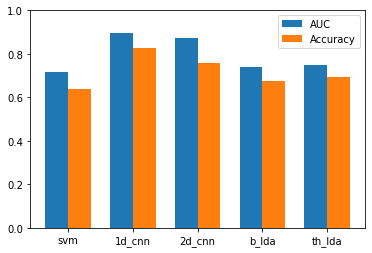

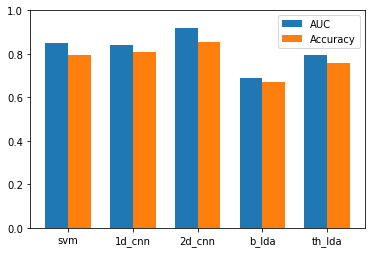

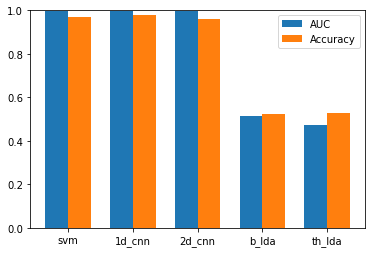

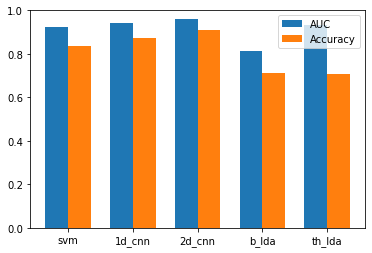

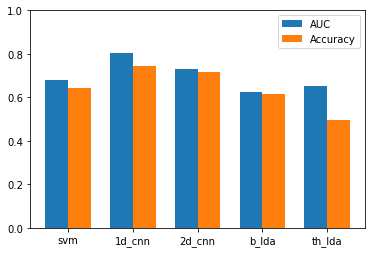

In [245]:
for ii in range(1, 9):

    for set_id, dataset in enumerate(["Pegboard", "Pouring", "Posture"]):

        x_coord = ii*offset_pat + set_id * offset_set
        if dataset == "Pouring":
            xticks.append(x_coord + 2*offset_cls)
            xticklabels.append(f"ET{ii}")

        try:
            missing_for_pat = missing_datasets[ii]
        except:
            missing_for_pat = dict()

        if dataset not in missing_for_pat:
            PKL_SOURCE = (
                DATA_PATH
                / "results"
                / f"ET{ii}"
                / Path(dataset + "_off").with_suffix(".p")
            )
            results = pickle.load(open(PKL_SOURCE, "rb"))

            FIG_TARGET = DATA_PATH / 'results' / f"ET{ii}" / Path(dataset+'_acc_runAllv1').with_suffix('.png')

            accs = [get_metric(results,'accuracy')[key]['valid'] for key in ['svm','1d-cnn', '2d-cnn','b-lda', 'th-lda']]
            accs = [el['mean'] if isinstance(el,dict) else el for el in accs]

            aucs = [get_metric(results,'AUC')[key]['valid'] for key in ['svm','1d-cnn', '2d-cnn','b-lda', 'th-lda']]
            aucs = [el['mean'] if isinstance(el,dict) else el for el in aucs]

            fig,ax = plt.subplots()

            width = 0.35

            rects1 = ax.bar(np.array(range(5))-width/2,aucs,width,label='AUC')
            rects2 = ax.bar(np.array(range(5))+width/2,accs,width,label='Accuracy')

            ax.set_xticks(np.array(range(5)))
            ax.set_xticklabels([el[:-7] for el in cls_keys])
            ax.legend()
            ax.set_ylim((0,1))
            
            plt.savefig(FIG_TARGET)

In [ ]:
plt.close('all')

In [ ]:
get_metric(results,'accuracy')

In [ ]:
missing_datasets = {3: 'Pouring', 5: 'Pegboard', 6: 'Pegboard', 8: 'Pegboard' }

In [ ]:
fig, ax = plt.subplots(figsize=(15, 5))
s = 20

svm_c = "C0"
cnn1d_c = "C1"
cnn2d_c = "C2"
b_lda_c = "C3"
th_lda_c = "C4"

offset_pat = 12
offset_set = 3
offset_cls = 0.3

xticks, xticklabels = [], []

for ii in range(1, 9):

    for set_id, dataset in enumerate(["Pegboard", "Pouring", "Posture"]):

        x_coord = ii*offset_pat + set_id * offset_set
        if dataset == "Pouring":
            xticks.append(x_coord + 2*offset_cls)
            xticklabels.append(f"ET{ii}")

        try:
            missing_for_pat = missing_datasets[ii]
        except:
            missing_for_pat = dict()

        if dataset not in missing_for_pat:

            PKL_SOURCE = (
                DATA_PATH
                / "results"
                / f"ET{ii}"
                / Path(dataset + "_off").with_suffix(".p")
            )
            results = pickle.load(open(PKL_SOURCE, "rb"))
            
            # SVM:
            ax.scatter(
                x_coord,
                results["svm_scores"]["AUC"]["valid"]["mean"],
                c=svm_c,
                marker="_",
                s=2 * s,
            )
            ax.scatter(
                x_coord,
                results["svm_scores"]["precision"]["valid"]["mean"],
                c=svm_c,
                marker="v",
                s=s,
            )
            ax.scatter(
                x_coord,
                results["svm_scores"]["recall"]["valid"]["mean"],
                c=svm_c,
                marker="^",
                s=s,
            )
            ax.plot(
                (x_coord, x_coord),
                (
                    results["svm_scores"]["precision"]["valid"]["mean"],
                    results["svm_scores"]["recall"]["valid"]["mean"],
                ),
                c=svm_c,
                linewidth=0.2,
                linestyle="--",
            )
            ax.scatter(
                x_coord,
                results["svm_scores"]["accuracy"]["valid"]["mean"],
                c=svm_c,
                marker="*",
                s=s,
            )

            # 1D-CNN:
            ax.scatter(
                x_coord + offset_cls,
                results["1d_cnn_scores"]["AUC"]["valid"],
                c=cnn1d_c,
                marker="_",
                s=2 * s,
            )
            ax.scatter(
                x_coord + offset_cls,
                results["1d_cnn_scores"]["precision"]["valid"],
                c=cnn1d_c,
                marker="v",
                s=s,
            )
            ax.scatter(
                x_coord + offset_cls,
                results["1d_cnn_scores"]["recall"]["valid"],
                c=cnn1d_c,
                marker="^",
                s=s,
            )
            ax.plot(
                (x_coord + offset_cls, x_coord + offset_cls),
                (
                    results["1d_cnn_scores"]["precision"]["valid"],
                    results["1d_cnn_scores"]["recall"]["valid"],
                ),
                c=cnn1d_c,
                linewidth=0.2,
                linestyle="--",
            )
            ax.scatter(
                x_coord + offset_cls,
                results["1d_cnn_scores"]["accuracy"]["valid"],
                c=cnn1d_c,
                marker="*",
                s=s,
            )

            # 2D-CNN:
            ax.scatter(
                x_coord + offset_cls *2,
                results["2d_cnn_scores"]["AUC"]["valid"],
                c=cnn2d_c,
                marker="_",
                s=2 * s,
            )
            ax.scatter(
                x_coord + offset_cls*2,
                results["2d_cnn_scores"]["precision"]["valid"],
                c=cnn2d_c,
                marker="v",
                s=s,
            )
            ax.scatter(
                x_coord + offset_cls*2,
                results["2d_cnn_scores"]["recall"]["valid"],
                c=cnn2d_c,
                marker="^",
                s=s,
            )
            ax.plot(
                (x_coord + offset_cls*2, x_coord + offset_cls*2),
                (
                    results["2d_cnn_scores"]["precision"]["valid"],
                    results["2d_cnn_scores"]["recall"]["valid"],
                ),
                c=cnn2d_c,
                linewidth=0.2,
                linestyle="--",
            )
            ax.scatter(
                x_coord + offset_cls*2,
                results["2d_cnn_scores"]["accuracy"]["valid"],
                c=cnn2d_c,
                marker="*",
                s=s,
            )

            
            # b-LDA:
            ax.scatter(
                x_coord + offset_cls * 3,
                results["b_lda_scores"]["AUC"]["valid"]["mean"],
                c=b_lda_c,
                marker="_",
                s=2 * s,
            )
            ax.scatter(
                x_coord + offset_cls * 3,
                results["b_lda_scores"]["precision"]["valid"]["mean"],
                c=b_lda_c,
                marker="v",
                s=s,
            )
            ax.scatter(
                x_coord + offset_cls * 3,
                results["b_lda_scores"]["recall"]["valid"]["mean"],
                c=b_lda_c,
                marker="^",
                s=s,
            )
            ax.plot(
                (x_coord + offset_cls * 3, x_coord + offset_cls * 3),
                (
                    results["b_lda_scores"]["precision"]["valid"]["mean"],
                    results["b_lda_scores"]["recall"]["valid"]["mean"],
                ),
                c=b_lda_c,
                linewidth=0.2,
                linestyle="--",
            )
            ax.scatter(
                x_coord + offset_cls * 4,
                results["b_lda_scores"]["accuracy"]["valid"]["mean"],
                c=b_lda_c,
                marker="*",
                s=s,
            )


            # th-LDA:
            ax.scatter(
                x_coord + offset_cls * 4,
                results["th_lda_scores"]["AUC"]["valid"]["mean"],
                c=th_lda_c,
                marker="_",
                s=2 * s,
            )
            ax.scatter(
                x_coord + offset_cls * 4,
                results["th_lda_scores"]["precision"]["valid"]["mean"],
                c=th_lda_c,
                marker="v",
                s=s,
            )
            ax.scatter(
                x_coord + offset_cls * 4,
                results["th_lda_scores"]["recall"]["valid"]["mean"],
                c=th_lda_c,
                marker="^",
                s=s,
            )
            ax.plot(
                (x_coord + offset_cls * 4, x_coord + offset_cls * 4),
                (
                    results["th_lda_scores"]["precision"]["valid"]["mean"],
                    results["th_lda_scores"]["recall"]["valid"]["mean"],
                ),
                c=th_lda_c,
                linewidth=0.2,
                linestyle="--",
            )
            ax.scatter(
                x_coord + offset_cls * 4,
                results["th_lda_scores"]["accuracy"]["valid"]["mean"],
                c=th_lda_c,
                marker="*",
                s=s,
            )

        else:
            ax.scatter(x_coord + offset_cls*2, 1, c="r", marker="s", s=2 * s, alpha=0.2)

ax.set_xticks(xticks)
ax.set_xticklabels(xticklabels)

from matplotlib.lines import Line2D

legend_elements = [
    Line2D([0], [0], color=svm_c, lw=4, label="SVM"),
    Line2D([0], [0], color=cnn1d_c, lw=4, label="1D-CNN"),
    Line2D([0], [0], color=cnn2d_c, lw=4, label="2D-CNN"),
    Line2D([0], [0], color=b_lda_c, lw=4, label="b-LDA"),
    Line2D([0], [0], color=th_lda_c, lw=4, label="th-LDA")
]
leg = ax.legend(handles=legend_elements, loc="lower left")
ax.add_artist(leg)

legend_elements = [
    Line2D([0], [0], lw=0, marker="_", color="gray", label="AUC", markersize=5),
    Line2D([0], [0], lw=0, marker="v", color="gray", label="precision", markersize=5),
    Line2D([0], [0], lw=0, marker="^", color="gray", label="recall", markersize=5),
    Line2D([0], [0], lw=0, marker="*", color="gray", label="accuracy", markersize=5),
]

leg = plt.legend(handles=legend_elements, loc="lower right")
ax.add_artist(leg)
ax.set_title("Decoding Results @750 ms")

In [ ]:
plt.close('all')

In [ ]:


svm_c = "C0"
cnn1d_c = "C1"
cnn2d_c = "C2"
b_lda_c = "C3"
th_lda_c = "C4"


offset_pat = 12
offset_set = 3
offset_cls = 0.3

cls_keys = ['svm_scores', '1d_cnn_scores', '2d_cnn_scores', 'b_lda_scores', 'th_lda_scores']
xticks, xticklabels = [], []

AUC_CONTS = [[],[],[],[],[]]

for ii in range(1, 9):

    for set_id, dataset in enumerate(["Pegboard", "Pouring", "Posture"]):

        x_coord = ii*offset_pat + set_id * offset_set
        if dataset == "Pouring":
            xticks.append(x_coord + 2*offset_cls)
            xticklabels.append(f"ET{ii}")

        try:
            missing_for_pat = missing_datasets[ii]
        except:
            missing_for_pat = dict()

        if dataset not in missing_for_pat:
            PKL_SOURCE = (
                DATA_PATH
                / "results"
                / f"ET{ii}"
                / Path(dataset + "_off").with_suffix(".p")
            )
            results = pickle.load(open(PKL_SOURCE, "rb"))
            
            for jj,key in enumerate(cls_keys):
                if key in ['svm_scores', 'b_lda_scores', 'th_lda_scores']:
                    AUC_CONTS[jj].append(results[key]['accuracy']['valid']['mean'])
                else:
                    AUC_CONTS[jj].append(results[key]['accuracy']['valid'])


data_df = pd.DataFrame()
for jj,key in enumerate(cls_keys):
    data_df = data_df.append(pd.DataFrame([np.repeat(jj,len(AUC_CONTS[jj])),AUC_CONTS[jj]]).transpose())

data_df.rename(columns={0:"cls",1:"y"},inplace=True)


In [ ]:
AUC_arr = np.array(AUC_CONTS)

In [ ]:
import seaborn as sns

fig, ax = plt.subplots()

ax  = sns.violinplot(x="cls",y="y",data=data_df,ax=ax,inner='point',palette=plt.rcParams['axes.prop_cycle'].by_key()['color'])
ax.set_xticklabels([key[:-7] for key in cls_keys])
ax.set_title(f'Comoposite Valid Accuracy (n = {len(AUC_CONTS[0])})')
ax.set_xlabel('');ax.set_ylabel('Accuracy Score')


ax.plot(AUC_arr,c='k',linewidth=0.2);


In [ ]:
fig.savefig('composite Accuracy.png')

In [ ]:
plt.close('all')